# Contents <a id='beginning'></a>
## 1. Description  (#description)
2. []
1. [Empirical Cumulative Distribution Function](#section1)
2. [Заголовок второго раздела](#section2)
    1. [Подраздел](#subsection1)

## Заголовок первого раздела <a id='section5'></a>

Текст первого раздела...

## Заголовок второго раздела <a id='section2'></a>

Текст второго раздела...

### Подраздел <a id='subsection1'></a>

Текст подраздела...

## 1. Description 

CSFAIL.LIVE is a site for CS:GO skin trading, with certain features and opportunities for users.
One of the opportunities is gambling game https://csfail.live/en/crash.
The recource generates quite a lot of not very sophisticated data.
Although it does not have any API the data is not protected from collecting using Selenium library.
The purpose of the project is to collect historical data from the site and answer several questions:
1. In what extent we can account the game honest / flaudulent
    - what does "ratio" distribution look like?
    - is "ratio" distribution stationary?
    - are there exist any "unusual" players?
    
2. What is average profitability of the recourse?
3. What play strategy could be optimal in some sense given the "ratio" distribution?
4. To what classes players can be divided?


In [1]:
import pandas as pd
import time
import datetime
import matplotlib_inline
import pickle
import matplotlib.pyplot as plt
import math

In [18]:
with open('./csfail_rounds_w_persons.pkl', 'rb') as f:
    bets = pickle.load(f)
bets.rename(columns={"Ratio" : "BetRatio"}, inplace=True)

with open('./csfail_history.pkl', 'rb') as f:
    rounds = pickle.load(f)

df = pd.merge(bets, rounds, on="Round")
df["BankCalculated"] = df.groupby('Round')["Stake"].sum()
print(rounds.columns)
print(bets.describe())
print(df.head())

Index(['Round', 'Time', 'GrabDate', 'Bank', 'PersonsNumber', 'Ratio'], dtype='object')
               Stake            Win       BetRatio
count  782961.000000  782961.000000  782961.000000
mean       55.807615      20.038005       3.638869
std       164.979239     237.134837      77.063246
min         0.090000  -34031.250000       1.010000
25%         1.410000      -2.320000       1.190000
50%         2.690000       0.960000       1.500000
75%         8.250000       4.660000       2.050000
max     34031.250000   29044.120000    9999.000000
     Round  Stake    Win  BetRatio  \
0  3927588  15.49  15.64      1.01   
1  3927588  14.82  22.11      1.50   
2  3927588  14.39  17.24      1.20   
3  3927588  13.81  20.71      1.50   
4  3927588  13.45  14.80      1.10   

                                              Player   Time    GrabDate  \
0  https://avatars.steamstatic.com/df250f7624cb85...  16:10  19-05-2023   
1  https://avatars.steamstatic.com/9a1ea30e01cc15...  16:10  19-05-2023   


 Рассмотрим **сумму** *$\sum_{n=1}^{N} n^2$*

### 1. Distribution of number of players in a round, bank size, ratio



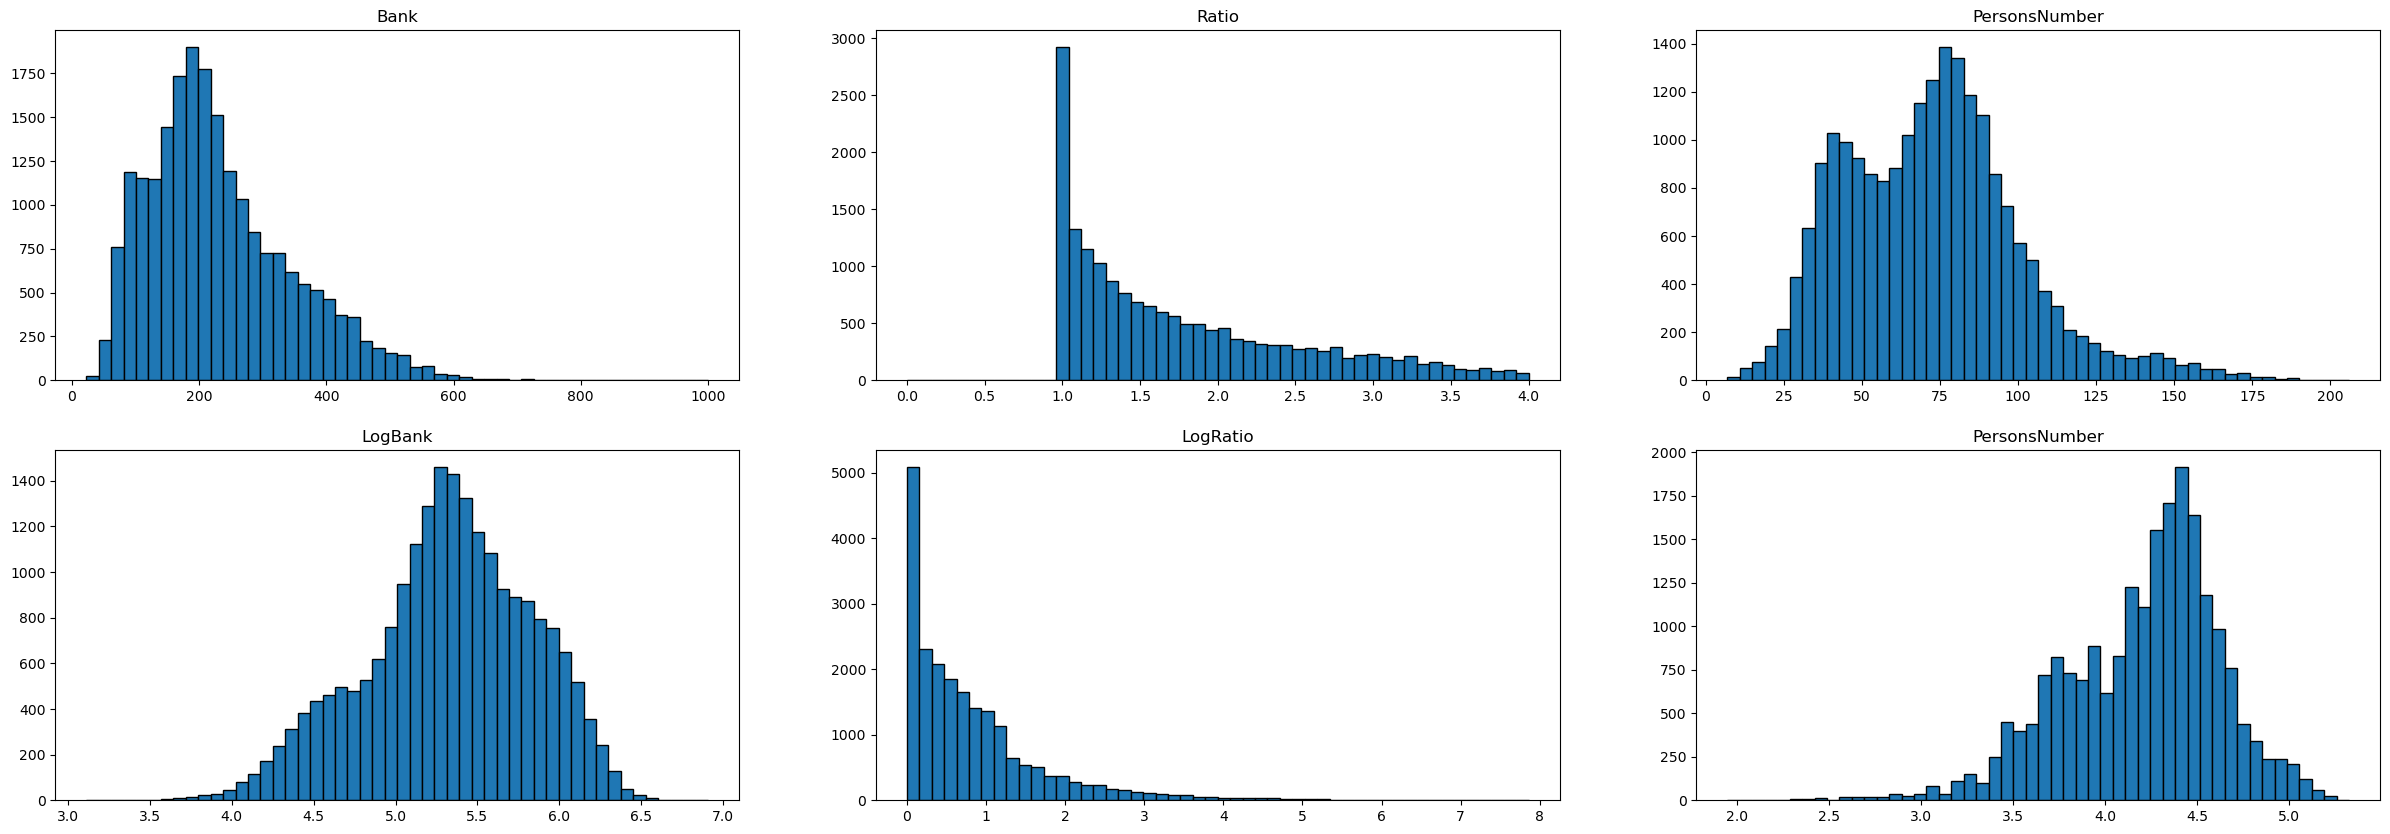

In [2]:
with open('./csfail_history.pkl', 'rb') as f:
    history = pickle.load(f)
history["Log_Bank"] = history["Bank"].apply(lambda x: math.log(x))
history["Log_Ratio"] = history["Ratio"].apply(lambda x: math.log(x))
history["Log_PersonsNumber"] = history["PersonsNumber"].apply(lambda x: math.log(x))

min_log_bank = history["Log_Bank"].min()
min_log_ratio = history["Log_Ratio"].min()
min_log_personsnumber = history["Log_PersonsNumber"].min()


history["LogLog_Bank"] = history["Log_Bank"].apply(lambda x: math.log(x-min_log_bank+1))
history["LogLog_Ratio"] = history["Log_Ratio"].apply(lambda x: math.log(x-min_log_ratio+1))
history["LogLog_PersonsNumber"] = history["Log_PersonsNumber"].apply(lambda x: math.log(x - min_log_personsnumber+1))


"""
min_log_stake = rounds["Log_Stake"].min()
min_log_ratio = rounds["Log_Ratio"].min()
rounds["LogLog_Stake"] = rounds["Log_Stake"].apply(lambda x: math.log(x-min_log_stake+1))
rounds["LogLog_Ratio"] = rounds["Log_Ratio"].apply(lambda x: math.log(x-min_log_ratio+1))
print(rounds.describe())
"""

fig, axs = plt.subplots(2, 3, figsize=(30, 10))

axs[0, 0].hist(history['Bank'], bins=50, edgecolor='black')  # 'bins' - это количество столбцов в гистограмме
axs[0, 0].set_title('Bank')
#axs[0, 0].set_xlabel('Bank')
#axs[0, 0].set_ylabel('Samples')

axs[0, 1].hist(history['Ratio'], bins=50, edgecolor='black', range=(0, 4))
axs[0, 1].set_title('Ratio')

#axs[0, 1].set_xlabel('Ratio')
#axs[0, 1].set_ylabel('Samples')

axs[0, 2].hist(history['PersonsNumber'], bins=50, edgecolor='black')
axs[0, 2].set_title('PersonsNumber')
#axs[0, 2].set_xlabel('PersonsNumber')
#axs[0, 2].set_ylabel('Samples')

axs[1, 0].hist(history['Log_Bank'], bins=50, edgecolor='black')  # 'bins' - это количество столбцов в гистограмме
axs[1, 0].set_title('LogBank')
#axs[1, 0].set_xlabel('Log_Bank')
#axs[1, 0].set_ylabel('Samples')
#
axs[1, 1].hist(history['Log_Ratio'], bins=50, edgecolor='black')
axs[1, 1].set_title('LogRatio')
#axs[1, 1].set_xlabel('Log_Ratio')
#axs[1, 1].set_ylabel('Samples')

axs[1, 2].hist(history['Log_PersonsNumber'], bins=50, edgecolor='black')
axs[1, 2].set_title('PersonsNumber')
#axs[1, 2].set_xlabel('Log_PersonsNumber')
#axs[1, 2].set_ylabel('Samples')




plt.show()


### Empirical Cumulative Distribution Function <a id='section1'></a> [top](#beginning)

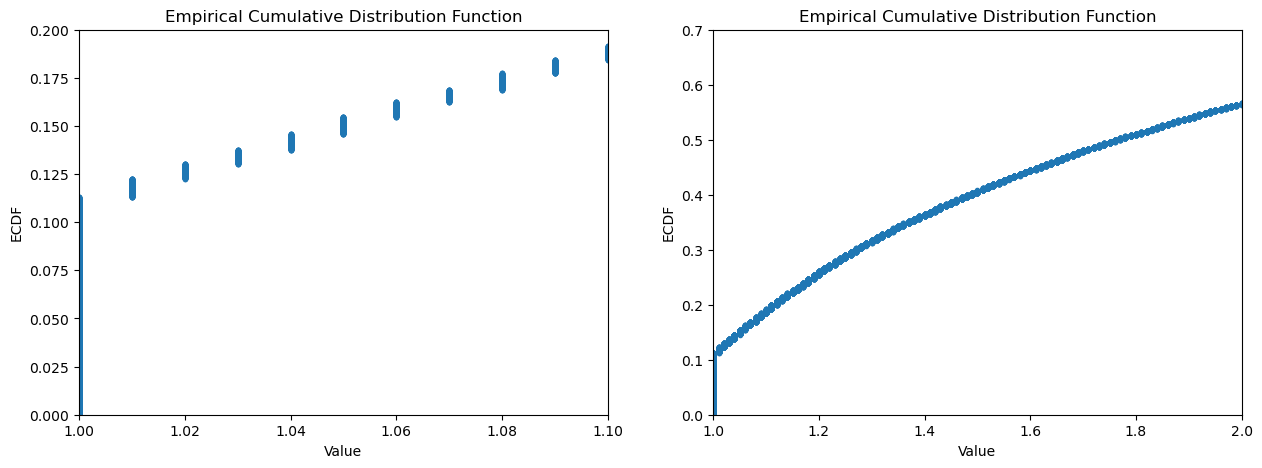

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Выберем столбец для анализа
col = history['Ratio']

fig, axs = plt.subplots(1,2, figsize=(15, 5))

x = np.sort(col)
y = np.arange(1, len(col) + 1) / len(col)
axs[0].plot(x, y, marker='.', linestyle='none')
axs[0].set_title('Empirical Cumulative Distribution Function')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('ECDF')
axs[0].set_xlim(1,1.1)
axs[0].set_ylim(0,0.2)

axs[1].plot(x, y, marker='.', linestyle='none')
axs[1].set_title('Empirical Cumulative Distribution Function')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('ECDF')
axs[1].set_xlim(1,2)
axs[1].set_ylim(0,0.7)



plt.show()

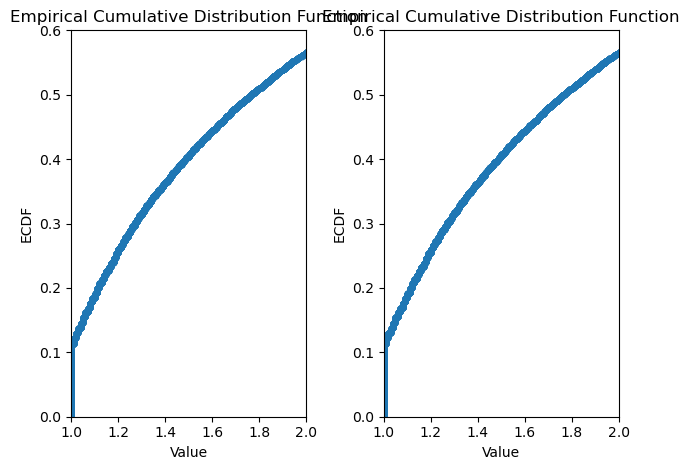

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats



# Выберем столбец для анализа
col = history['Ratio']


# Строим график ECDF
plt.subplot(1, 2, 1)
x = np.sort(col)
y = np.arange(1, len(col) + 1) / len(col)
plt.plot(x, y, marker='.', linestyle='none')
plt.title('Empirical Cumulative Distribution Function')
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim(1,2)
plt.ylim(0,0.6)

# Строим график ECDF
plt.subplot(1, 2, 2)
x = np.sort(col)
y = np.arange(1, len(col) + 1) / len(col)
plt.plot(x, y, marker='.', linestyle='none')
plt.title('Empirical Cumulative Distribution Function')
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.xlim(1,2)
plt.ylim(0,0.6)

# Показываем графики
plt.tight_layout()
plt.show()

### Distribution of Stake size and ratio, chosen by players in a round

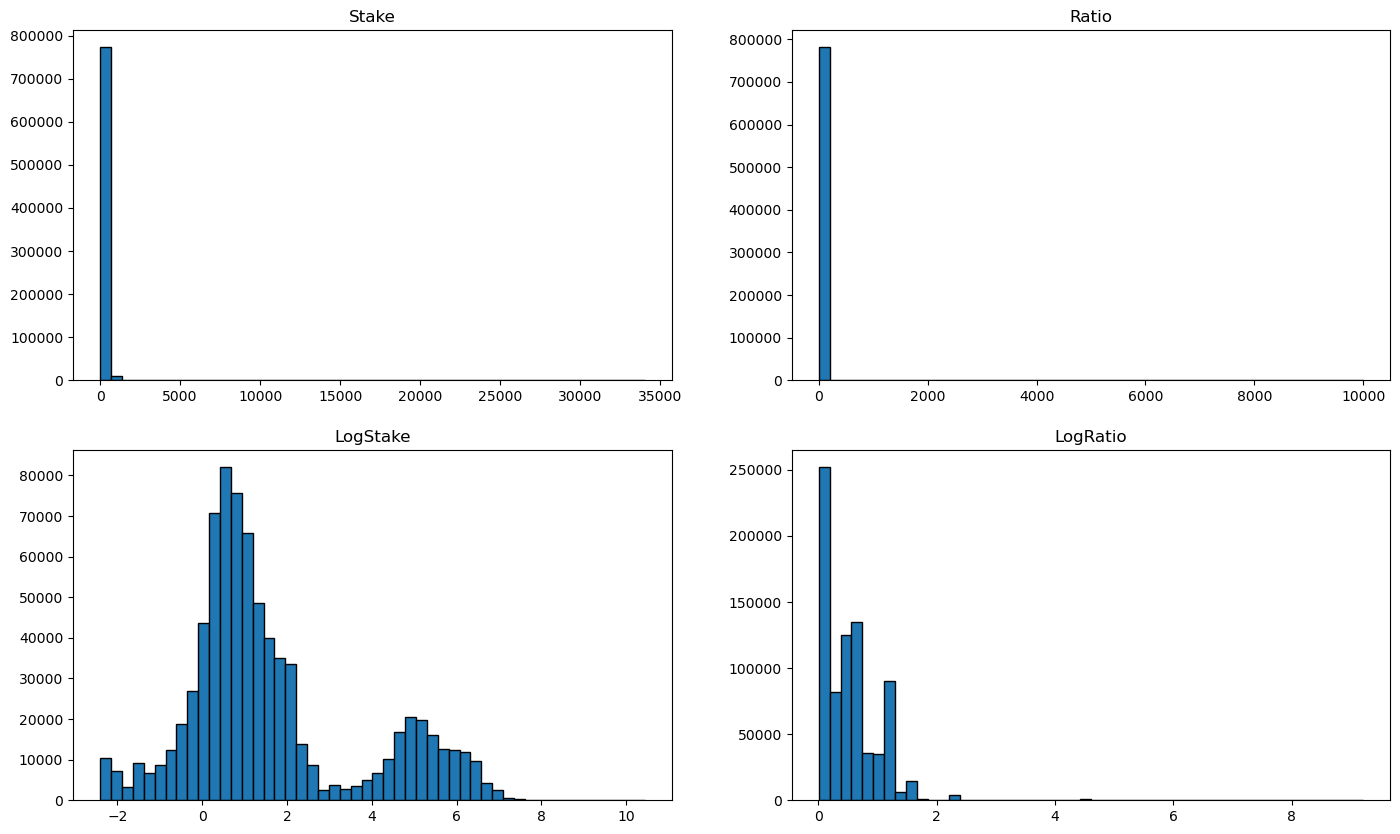

In [5]:
import matplotlib.pyplot as plt
import math
with open('./csfail_rounds_w_persons.pkl', 'rb') as f:
    rounds = pickle.load(f)
rounds["Log_Stake"] = rounds["Stake"].apply(lambda x: math.log(x))
rounds["Log_Ratio"] = rounds["Ratio"].apply(lambda x: math.log(x))
min_log_stake = rounds["Log_Stake"].min()
min_log_ratio = rounds["Log_Ratio"].min()
rounds["LogLog_Stake"] = rounds["Log_Stake"].apply(lambda x: math.log(x-min_log_stake+1))
rounds["LogLog_Ratio"] = rounds["Log_Ratio"].apply(lambda x: math.log(x-min_log_ratio+1))

fig, axs = plt.subplots(2, 2, figsize=(17, 10))

axs[0, 0].hist(rounds['Stake'], bins=50, edgecolor='black')  # 'bins' - это количество столбцов в гистограмме
axs[0, 0].set_title('Stake')
#axs[0, 0].set_xlabel('Stake')
#axs[0, 0].set_ylabel('Количество')

axs[0, 1].hist(rounds['Ratio'], bins=50, edgecolor='black')
axs[0, 1].set_title('Ratio')
#axs[0, 1].set_xlabel('Ratio')
#axs[0, 1].set_ylabel('Samples')

axs[1, 0].hist(rounds['Log_Stake'], bins=50, edgecolor='black')  # 'bins' - это количество столбцов в гистограмме
axs[1, 0].set_title('LogStake')
#axs[1, 0].set_xlabel('LogStake')
#axs[1, 0].set_ylabel('Samples')

axs[1, 1].hist(rounds['Log_Ratio'], bins=50, edgecolor='black')
axs[1, 1].set_title('LogRatio')
#axs[1, 1].set_xlabel('LogRatio')
#axs[1, 1].set_ylabel('Samples')


plt.show()


In [6]:
print(rounds[rounds["Ratio"]>100][["Round","Stake", "Ratio", "Log_Stake", "Log_Ratio", "LogLog_Stake", "LogLog_Ratio"]])




          Round   Stake   Ratio  Log_Stake  Log_Ratio  LogLog_Stake  \
5637    3927657    0.10   111.0  -2.302585   4.709530      0.100172   
5713    3927658    0.10   111.0  -2.302585   4.709530      0.100172   
5779    3927659    0.10   111.0  -2.302585   4.709530      0.100172   
7253    3927678    0.10   111.0  -2.302585   4.709530      0.100172   
11671   3927723    1.51  9999.0   0.412110   9.210240      1.340265   
...         ...     ...     ...        ...        ...           ...   
777674  3936753  176.03   142.0   5.170654   4.955827      2.149271   
781484  3936801    0.88   142.0  -0.127833   4.955827      1.187878   
781691  3936804    1.76   142.0   0.565314   4.955827      1.379587   
781779  3936805    2.71   142.0   0.996949   4.955827      1.482716   
781858  3936806    4.64   142.0   1.534714   4.955827      1.597904   

        LogLog_Ratio  
5637        1.740392  
5713        1.740392  
5779        1.740392  
7253        1.740392  
11671       2.322416  
...      

In [7]:

rounds[rounds["Round"]==3928551].count()


Round           54
Stake           54
Win             54
Ratio           54
Player          54
Log_Stake       54
Log_Ratio       54
LogLog_Stake    54
LogLog_Ratio    54
dtype: int64

PLAYERS - Who are they?